In [1]:
import os
import cv2
import bcolz
import random
import imutils
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
%matplotlib inline

Using TensorFlow backend.


In [2]:
%%time
dpath = '/home/m20163692/data/sr_data/'
arr_lr = bcolz.open(os.path.join(dpath, 'trn_resized_72.bc'))[:]
arr_hr = bcolz.open(os.path.join(dpath, 'trn_resized_288.bc'))[:]
hr_shp = arr_hr.shape[1:]
lr_shp = arr_lr.shape[1:]

CPU times: user 17.8 s, sys: 27.6 s, total: 45.4 s
Wall time: 1min


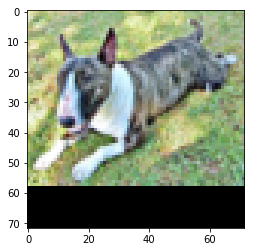

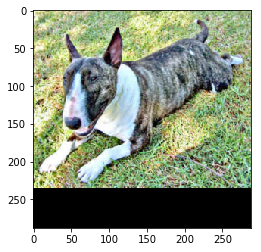

In [185]:
i = random.choice(range(len(arr_lr)))
plt.imshow(arr_lr[i].astype(np.uint8))
plt.show()
plt.imshow(arr_hr[i].astype(np.uint8))
plt.show()

In [4]:
from keras.models import Model
from keras.layers import *
from keras import backend as K

def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, size, strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return Add()([x, ip])

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, size, padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [5]:
inp = Input(arr_lr.shape[1:])

x = conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
    
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = Convolution2D(3, 9, activation='tanh', padding='same')(x)

outp = Lambda(lambda x: (x+1)*127.5)(x)

In [6]:
vgg_inp = Input(hr_shp)
vgg =  VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [7]:
def get_outp(model, ln):
    return model.get_layer(f'block{ln}_conv1').output

vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])

vgg1 = vgg_content(vgg_inp) # Real High res image
vgg2 = vgg_content(outp)    # Generated High res image

In [8]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

w = [0.1, 0.8, 0.1]

def content_fn(x): 
    res = 0
    n = len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [9]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))
m_sr.compile('adam', 'mse')

In [18]:
m_sr.fit([arr_lr, arr_hr], targ, 8, 2)

Epoch 1/2
19439/19439 [==============================] - 5942s - loss: 24114.4779  
Epoch 2/2
19439/19439 [==============================] - 5824s - loss: 21208.3661  


In [ ]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1)

In [63]:
top_model = Model(inp, outp)

In [102]:
top_model.save('model_data.h5')
top_model.save_weights('model_data_w.h5')

# Test model

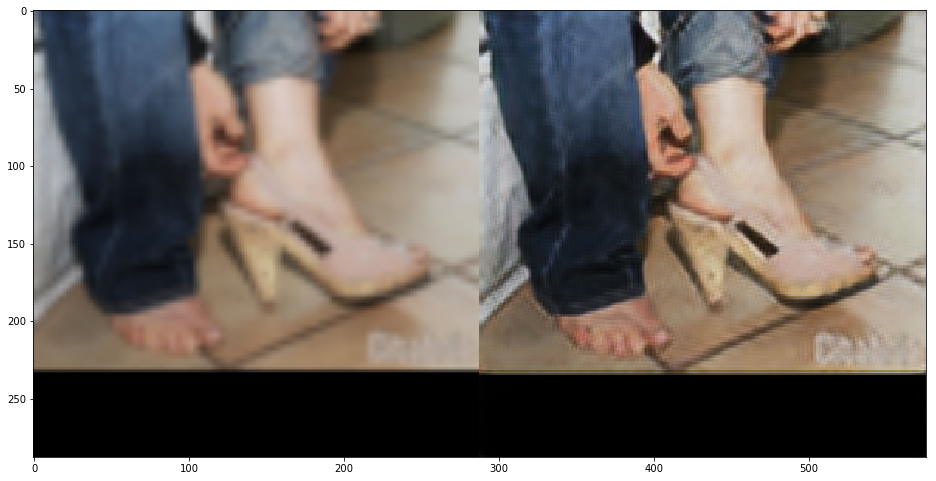

In [101]:
i = random.randint(0,len(arr_lr)-1)
p = top_model.predict(arr_lr[i:i+1])
img1 = cv2.resize(arr_lr[i], p[0].shape[:2]).astype(np.uint8)
img2 = p[0].astype(np.uint8)
plt.figure(figsize=(16,16))
plt.imshow(np.hstack([img1, img2]))
plt.show()

# Test on different size image

In [175]:
pic = plt.imread('P70301-102125.jpg')
print(pic.shape)
pic = cv2.resize(pic, (pic.shape[1]//50, pic.shape[0]//50), pic.shape[2])
print(pic.shape)
pic = np.expand_dims(pic, 0)

(3936, 5248, 3)
(78, 104, 3)


In [176]:
inp = Input(pic.shape[1:])

x = conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
    
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = Convolution2D(3, 9, activation='tanh', padding='same')(x)

outp = Lambda(lambda x: (x+1)*127.5)(x)
top_model = Model(inp, outp)
top_model.load_weights('model_data_w.h5')

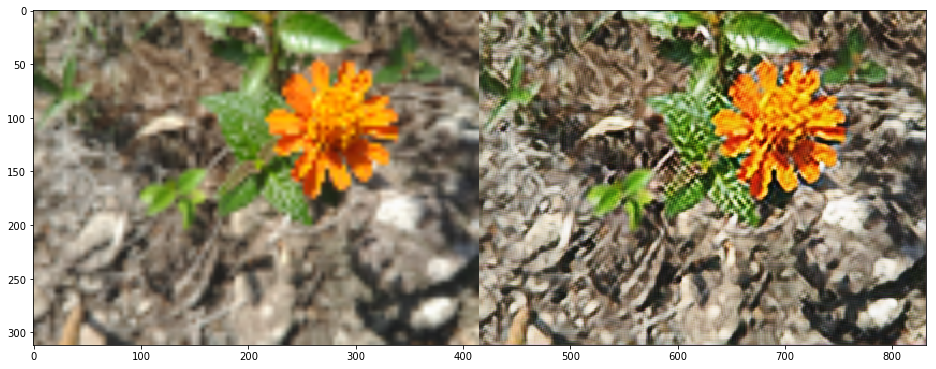

In [177]:
ipic = top_model.predict(pic)
img1 = cv2.resize(pic[0], ipic[0].shape[:2][::-1]).astype(np.uint8)
img2 = ipic[0].astype(np.uint8)
plt.figure(figsize=(16,16))
plt.imshow(np.hstack([img1, img2]))
plt.show()